In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

100%|██████████| 778M/778M [00:21<00:00, 38.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt

In [ ]:
# Set the base path for the dataset

base_path = "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset"


# Define subsets
subsets = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

In [ ]:
# Initialize lists for data and labels
data = []
labels = []

# Define image size for resizing
img_size = (128, 128)

# Load images and labels
for subset in subsets:
    image_dir = os.path.join(base_path, subset, "images")
    if os.path.exists(image_dir):
        image_files = os.listdir(image_dir)
        print(f"{subset}: Found {len(image_files)} images.")

        for image_name in image_files:
            image_path = os.path.join(image_dir, image_name)
            try:
                # Load and preprocess the image
                img = Image.open(image_path).convert("L")  # Convert to grayscale
                img = img.resize(img_size)
                img_array = img_to_array(img) / 255.0  # Normalize
                data.append(img_array)
                labels.append(subset)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    else:
        print(f"{subset}: No directory found.")

# Debug: Check if data and labels are populated
print(f"Number of samples: {len(data)}")
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {set(labels)}")

COVID: Found 3616 images.
Lung_Opacity: Found 6012 images.
Normal: Found 10192 images.
Viral Pneumonia: Found 1345 images.
Number of samples: 21165
Number of labels: 21165
Unique labels: {'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'COVID'}


In [ ]:
# Convert data and labels to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)


In [ ]:

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_size[0], img_size[1], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(subsets), activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.metrics import Precision

# Compile the model with precision and accuracy
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", Precision()])

# Train the model
history = model.fit( X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6059 - loss: 0.9386 - precision: 0.7011 - val_accuracy: 0.7725 - val_loss: 0.5690 - val_precision: 0.8001
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7638 - loss: 0.6146 - precision: 0.8113 - val_accuracy: 0.8053 - val_loss: 0.5013 - val_precision: 0.8362
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8045 - loss: 0.5113 - precision: 0.8389 - val_accuracy: 0.8287 - val_loss: 0.4417 - val_precision: 0.8433
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8322 - loss: 0.4297 - precision: 0.8586 - val_accuracy: 0.8290 - val_loss: 0.4321 - val_precision: 0.8479
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8501 - loss: 0.3970 - precision: 0.8733 - val_accuracy: 0.8394 - val_loss: 0.4217 - val_precision: 0.8550
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8672 - loss: 0.3488 - precision: 0.8832 - val_accuracy: 0.8309 - 

In [ ]:
model.save('covid_cnn_model.keras')

In [ ]:
#Save the Label encoder
import pickle

# Save the LabelEncoder object
label_encoder_filename = "label_encoder.pkl"
with open(label_encoder_filename, "wb") as file:
    pickle.dump(label_encoder, file)

In [ ]:
from tqdm import tqdm
import numpy as np

# Predict on test data
predictions = model.predict(X_test, verbose=0)

# Get the predicted classes and true classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calculate overall accuracy
overall_accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)

# Print the overall test accuracy with the progress bar-like format
total_steps = len(X_test)  # Set total steps for progress bar
with tqdm(total=total_steps, desc="Evaluating", unit="file") as pbar:
    for i in range(len(X_test)):
        pbar.update(1)

# Print the overall accuracy in the same style as your example
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")

# Decode class indices to labels
class_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(true_classes)

# Print accuracy for individual files
print("\nFile-level accuracy:")
for i in range(len(X_test)):
    print(f"File {i + 1}:")
    print(f"  Predicted Label: {class_labels[i]}")
    print(f"  True Label: {true_labels[i]}")
    print(f"  Correct: {class_labels[i] == true_labels[i]}")
    print("-" * 30)

Evaluating: 100%|██████████| 4233/4233 [00:00<00:00, 889637.16file/s]


Streaming output truncated to the last 5000 lines.
File 3234:
  Predicted Label: Normal
  True Label: Normal
  Correct: True
------------------------------
File 3235:
  Predicted Label: Normal
  True Label: Normal
  Correct: True
------------------------------
File 3236:
  Predicted Label: Lung_Opacity
  True Label: Lung_Opacity
  Correct: True
------------------------------
File 3237:
  Predicted Label: Normal
  True Label: Normal
  Correct: True
------------------------------
File 3238:
  Predicted Label: Lung_Opacity
  True Label: Lung_Opacity
  Correct: True
------------------------------
File 3239:
  Predicted Label: COVID
  True Label: COVID
  Correct: True
------------------------------
File 3240:
  Predicted Label: Lung_Opacity
  True Label: Normal
  Correct: False
------------------------------
File 3241:
  Predicted Label: Lung_Opacity
  True Label: Lung_Opacity
  Correct: True
------------------------------
File 3242:
  Predicted Label: Normal
  True Label: Normal
  Correct:

In [ ]:
import os

# Path to the dataset files
base_path = "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5"

# List directories in the base path to verify the available subsets
dataset_dirs = os.listdir(base_path)
print(f"Available directories in the dataset: {dataset_dirs}")

# List of subset directories to check
subdirectories = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

# Function to check and print image paths for each directory
def list_image_paths(base_path, subdirectories):
    for subdirectory in subdirectories:
        # Build the path to the subdirectory
        subdir_path = os.path.join(base_path, "COVID-19_Radiography_Dataset", subdirectory)

        if os.path.exists(subdir_path):
            print(f"\nListing images in the '{subdirectory}' directory:")
            # Check for 'images' subfolder in each subdirectory
            images_dir = os.path.join(subdir_path, "images")
            if os.path.exists(images_dir):
                image_files = os.listdir(images_dir)
                if image_files:
                    for image_file in image_files[:3]:  # Limit to first 3 images
                        image_path = os.path.join(images_dir, image_file)
                        print(f"  {image_path}")
                else:
                    print(f"  No images found in the '{subdirectory}/images' directory.")
            else:
                print(f"  No 'images' directory found inside the '{subdirectory}' folder.")
        else:
            print(f"  No '{subdirectory}' directory found in the 'COVID-19_Radiography_Dataset' folder.")

# Run the function to list image paths
list_image_paths(base_path, subdirectories)


Available directories in the dataset: ['COVID-19_Radiography_Dataset']

Listing images in the 'COVID' directory:
  /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID/images/COVID-173.png
  /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID/images/COVID-820.png
  /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID/images/COVID-2893.png

Listing images in the 'Lung_Opacity' directory:
  /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-3873.png
  /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1107.png
  /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/vers


Listing and processing 3 images in the 'COVID' directory:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


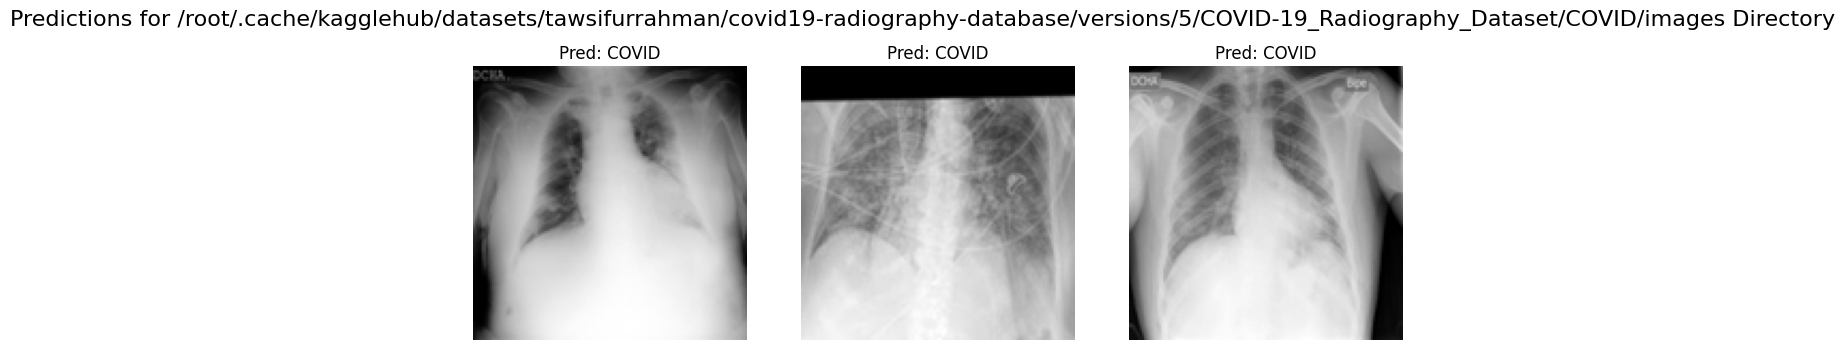


Listing and processing 3 images in the 'Lung_Opacity' directory:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


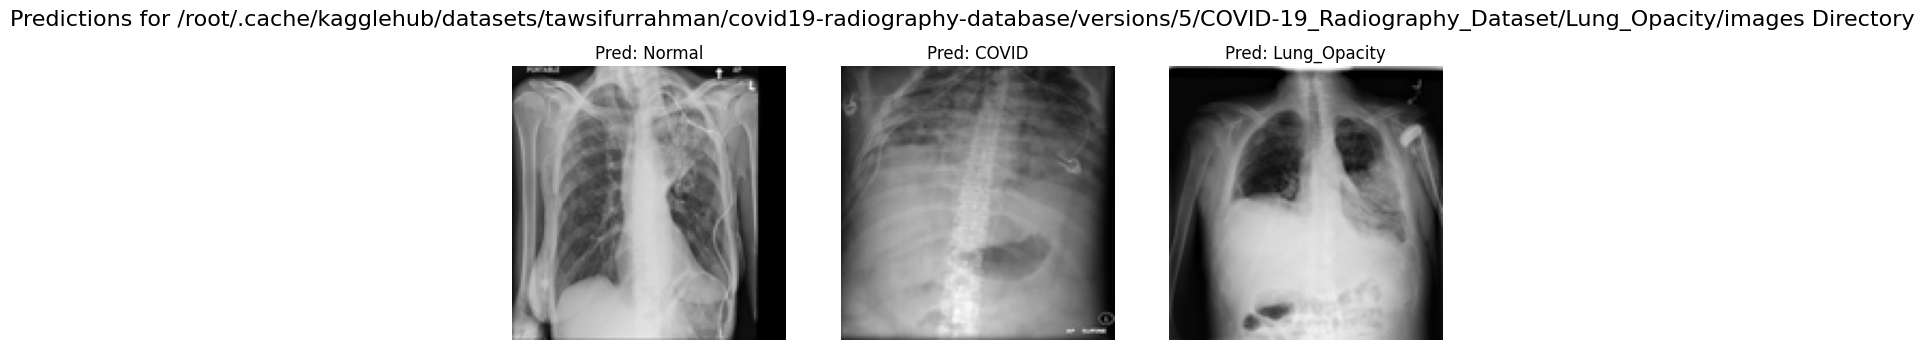


Listing and processing 3 images in the 'Normal' directory:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


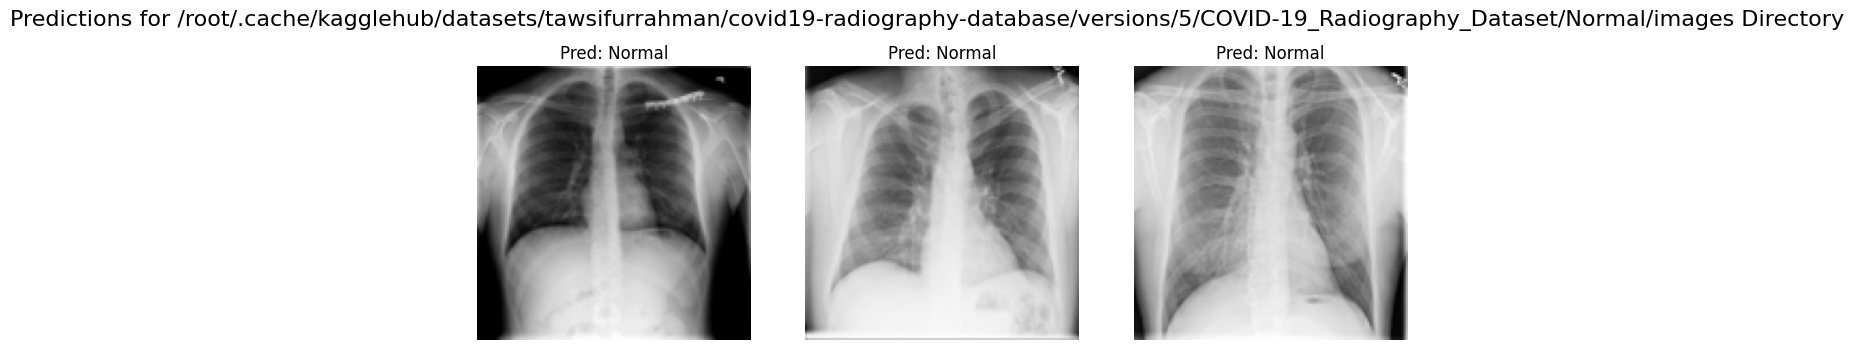


Listing and processing 3 images in the 'Viral Pneumonia' directory:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


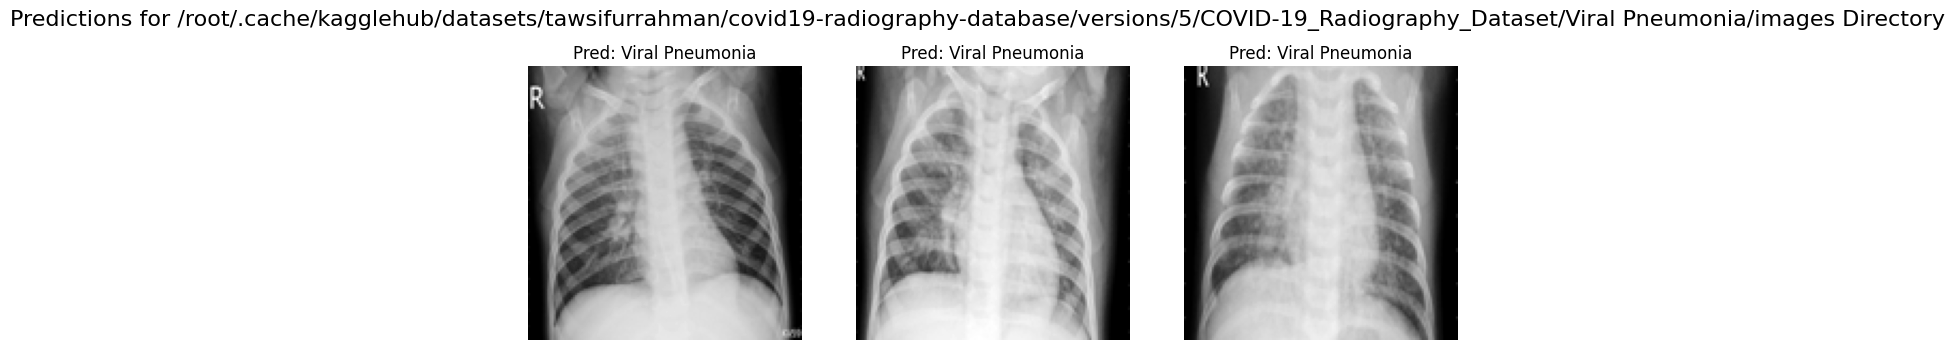

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import matplotlib.pyplot as plt

# Load the model
model = load_model('covid_cnn_model.keras')

# Define the image size (same as during training)
img_size = (128, 128)

# Example label_encoder, you should replace this with your actual label encoder
# This is just an example and should match your training setup
class_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Directories for each class
directories = {
    'COVID': "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID/images",
    'Lung_Opacity': "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Lung_Opacity/images",
    'Normal': "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Normal/images",
    'Viral Pneumonia': "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
}

# Function to predict the disease from an input image
def predict_disease(image_path, true_label=None):
    try:
        # Load and preprocess the input image
        img = Image.open(image_path).convert("L")  # Convert to grayscale
        img = img.resize(img_size)  # Resize to match model input
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Decode the predicted class label
        predicted_label = class_labels[predicted_class]

        return predicted_label, img
    except Exception as e:
        print(f"Error processing the image: {e}")
        return None, None

# Function to display 3 images and predictions from each directory
def display_images_in_directory(directory, true_label=None):
    image_files = os.listdir(directory)
    image_files = image_files[:3]  # Get only the first 3 images for display

    plt.figure(figsize=(12, 4))  # Adjust the size of the plot

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(directory, image_file)

        predicted_label, img = predict_disease(image_path, true_label)

        if img is not None:
            plt.subplot(1, 3, i+1)  # Create a subplot with 3 images per row
            plt.imshow(img, cmap='gray')
            plt.title(f"Pred: {predicted_label}")
            plt.axis('off')  # Hide axis

    plt.suptitle(f"Predictions for {directory} Directory", fontsize=16)
    plt.show()

# Display and predict for each directory (only 3 images from each)
for label, directory in directories.items():
    print(f"\nListing and processing 3 images in the '{label}' directory:")
    display_images_in_directory(directory, true_label=label)

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")


133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - accuracy: 0.8805 - loss: 0.3825 - precision: 0.8830
Test Loss: 0.3961440324783325
Test Accuracy: 0.877864420413971
Test Precision: 0.8806290030479431


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming `model` is your trained model and (X_test, y_test) is your test data
# y_test should be one-hot encoded; convert it to class labels for evaluation
y_test_classes = np.argmax(y_test, axis=1)

# Get predictions from the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=subsets)
print(report)

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
                 precision    recall  f1-score   support

          COVID       0.87      0.88      0.88       701
   Lung_Opacity       0.81      0.82      0.82      1246
         Normal       0.89      0.89      0.89      2024
Viral Pneumonia       0.97      0.88      0.92       262

       accuracy                           0.87      4233
      macro avg       0.88      0.87      0.87      4233
   weighted avg       0.87      0.87      0.87      4233

